In [8]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns

# Algorithm:

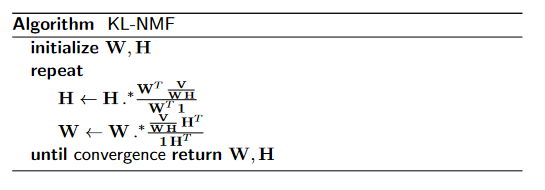

source: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf

# Decomposition: $V = WH$

$V ∈ R^{F \times T}$ - original non-negative data 

$W ∈ R^{F \times K}$ - matrix of basis vectors, dictionary elements. Not orthonormal, but commonly normalized to one

$H ∈ R^{K \times T}$ - matrix of activations, weights, or gains

In [93]:
# complexity worse case: iterations*fkt
# complexity best case: m*fkt
def NMF(V, K, max_iter=100, eps=0.0001):
    F, T = V.shape 
    W = np.random.rand(F, K)
    H = np.random.rand(K, T)
    
    ONES = np.ones((F, T))
    diffs = []
    for i in range(max_iter):
        # update activations
        # complexity (fkt)
        wh = np.matmul(W, H)
        # complexity (ft)
        v_div_wh = V / (wh)
        
        H *= np.matmul(W.transpose(), (v_div_wh + eps)) / np.matmul(W.transpose(), ONES)
        # update dictionary elements
        W *= np.matmul(V / (wh + eps), H.transpose()) / np.matmul(ONES, H.transpose()) 
        
        # ft
        diff = abs(np.linalg.norm(V - wh))
        
        diffs.append(diff)
        if diff <= eps: # convergence at var m
            print(i)
            break
    
    plt.plot(diffs, marker="*")
    plt.show()
    # normalize to sum to 1
    sumW = np.sum(W, axis=0)
    W = np.matmul(W, np.diag(1/sumW))
    H = np.matmul(np.diag(sumW), H)
    return np.dot(W, H), diffs

In [6]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])
        
        #if max_val > 1 or np.min(mixtures[i]) < 1:
        #    mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]

    if apply_noise:        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [12]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time)

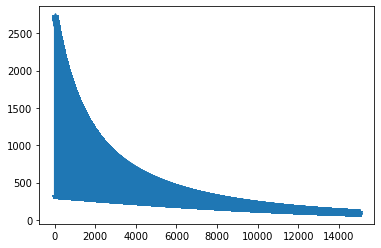

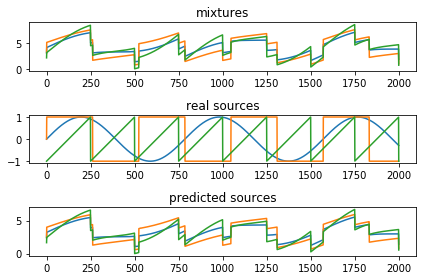

In [94]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
# make them all positive
X = X.T + -1 * np.min(X)
S, errors = NMF(X, K=3, max_iter=15000)
actual = mix_sources([s1,s2,s3])
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

In [96]:
e = np.average(errors) 

371.44735093786124